##### This notebook will generate the Keras model to forecast timeseries anomalies on the Numenta Anomaly Benchmark (NAB) dataset.


The dataset is publicly published, and for the purpose of this study we will analyze specifically 'art_daily_small_noise.csv' for training and the 'art_daily_jumpsup.csv' for testing.

In [43]:
# Import libraries
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import tensorflow as tf

In [6]:
data_root_url = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_training_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_training_url = data_root_url + df_training_suffix

df_training = pd.read_csv(df_training_url, parse_dates=True, index_col='timestamp')

df_training.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [7]:
df_test_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_test_url = data_root_url + df_test_suffix
df_test = pd.read_csv(
    df_test_url, parse_dates=True, index_col="timestamp"
)
df_test.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


## Plot data

Time to see how the data looks like and detect if there are any anomalies

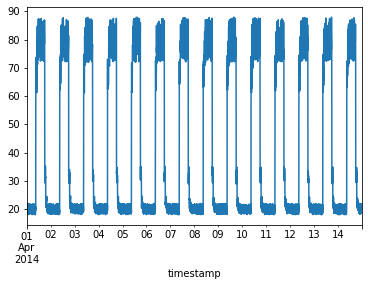

In [8]:
# For the training data, we can visualize it as follows
fig, ax = plt.subplots()
df_training.plot(legend=False, ax=ax)
plt.show()

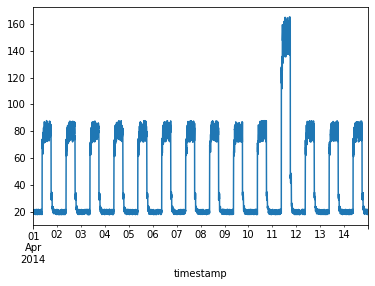

In [9]:
# For the test data, we can visualize it as follows
fig, ax = plt.subplots()
df_test.plot(legend=False, ax=ax)
plt.show()

Clearly, we can see there is a higher value than expected for this dataset. Now it is time for our model to predict if it detects it properly as an anomaly.

### Exploratory analysis

We will explore a bit deeper how the data looks like, and what are the values expected to be represented under statistic models.

For that, we can make use of the describe method as below

In [10]:
df_training.describe()

,value
count,4032.000000
mean,42.438353
std,28.077122
min,18.000964
25%,19.841390
50%,21.608487
75%,75.450282
max,87.976128


### Create sequences 
There is new value coming up every 5 min, so 12 every hour and 12*24 = 288 every day. as the data covers 14 days, we will have 4032 data points

In [15]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_training.mean()
training_std = df_training.std()
df_training_value = (df_training - training_mean) / training_std
print("Number of training samples:", len(df_training_value))
print("training samples:", df_training_value)


Number of training samples: 4032
training samples:                         value
timestamp                    
2014-04-01 00:00:00 -0.858829
2014-04-01 00:05:00 -0.728993
2014-04-01 00:10:00 -0.848148
2014-04-01 00:15:00 -0.729586
2014-04-01 00:20:00 -0.731173
...                       ...
2014-04-14 23:35:00 -0.791647
2014-04-14 23:40:00 -0.780255
2014-04-14 23:45:00 -0.833640
2014-04-14 23:50:00 -0.735102
2014-04-14 23:55:00 -0.846089

[4032 rows x 1 columns]


In [39]:
TIME_STEPS = 288

def create_sequences(values, time_steps=TIME_STEPS):
    output =  []
    for i in range(len(values) - time_steps +1):
        output.append(values[i:(i+time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
x_train.shape


(3745, 288, 1)

### Build the model

Now it is time to use the training dataset as input of the convolutional reconstruction autoencoder model. This model has as input shape the batch_size, sequence_length, num_features and will return an output of the same length.

In [24]:
model = keras.Sequential(
[
    layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
    layers.Conv1D(filters=32, kernel_size= 7, padding='same', strides=2, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Conv1D(filters=16, kernel_size= 7, padding='same', strides=2, activation='relu'),
    layers.Conv1DTranspose(filters=16, kernel_size= 7, padding='same', strides=2, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Conv1DTranspose(filters=32, kernel_size= 7, padding='same', strides=2, activation='relu'),
    layers.Conv1DTranspose(filters=1, kernel_size= 7, padding='same', activation='relu')
])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 144, 32)           256       
                                                                 
 dropout_2 (Dropout)         (None, 144, 32)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 144, 16)          1808      
 ranspose)                                                       
                                                                 
 dropout_3 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                            

### Training the model

It is time to use the training dataset as input and target for the model to be trained, as this is a reconstruction model

In [25]:
history = model.fit(
x_train,
x_train,
epochs=50,
batch_size=128,
validation_split=0.1,
callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')])



Epoch 1/50
27/27 [==============================] - 7s 197ms/step - loss: 0.5943 - val_loss: 0.4232
Epoch 2/50
27/27 [==============================] - 4s 145ms/step - loss: 0.4219 - val_loss: 0.4090
Epoch 3/50
27/27 [==============================] - 4s 150ms/step - loss: 0.4129 - val_loss: 0.4023
Epoch 4/50
27/27 [==============================] - 4s 154ms/step - loss: 0.4047 - val_loss: 0.3963
Epoch 5/50
27/27 [==============================] - 5s 185ms/step - loss: 0.4004 - val_loss: 0.3945
Epoch 6/50
27/27 [==============================] - 5s 188ms/step - loss: 0.3972 - val_loss: 0.3933
Epoch 7/50
27/27 [==============================] - 5s 188ms/step - loss: 0.3946 - val_loss: 0.3923
Epoch 8/50
27/27 [==============================] - 5s 196ms/step - loss: 0.3926 - val_loss: 0.3911
Epoch 9/50
27/27 [==============================] - 14s 529ms/step - loss: 0.3911 - val_loss: 0.3907
Epoch 10/50
27/27 [==============================] - 7s 237ms/step - loss: 0.3900 - val_loss: 0.391

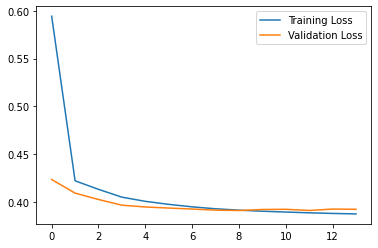

In [26]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

### Time to detect anomalies

Let's see how well our model can reconstruct anomalies from the input data.

First is to find the MAE loss on training samples
Then, find max MAE value as this is the worst value our model has predicted trying to guess a sample.That can be our threshold.
So, if the model finds a value higher than that threshold means that the pattern is not corresponding to what the model is used to find. For that, we can call it as an anomaly.


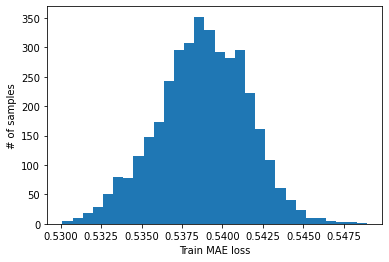

Reconstruction errror threshold 0.5489288909217599


In [27]:
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis = 1)

plt.hist(train_mae_loss, bins=30)
plt.xlabel('Train MAE loss')
plt.ylabel('# of samples')
plt.show()

# let's plot the reconstruction threshold
threshold = np.max(train_mae_loss)
print('Reconstruction errror threshold', threshold)


### Let's compare our reconstruction
We can see how our model has reconstructed the first sample. That's 288 timesteps from day 1 in the training dataset.

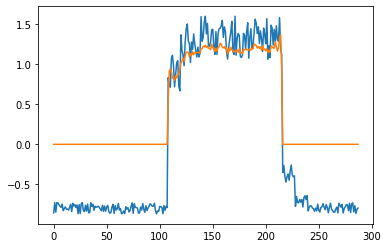

In [28]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()


### Normalize and prepare the test dataset

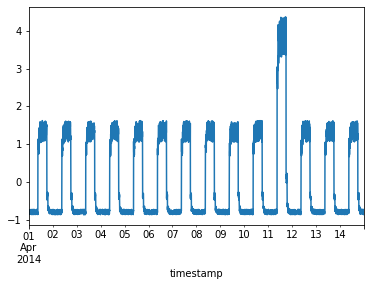

In [29]:
df_test_value = (df_test - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()



In [30]:

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)



Test input shape:  (3745, 288, 1)


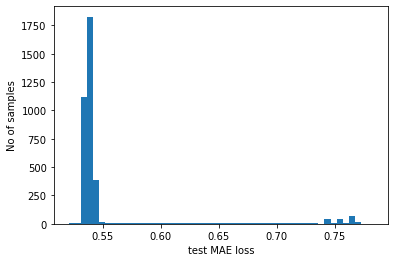

In [31]:

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()



In [32]:

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))


Number of anomaly samples:  395
Indices of anomaly samples:  (array([1658, 2522, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709,
       2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720,
       2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731,
       2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742,
       2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753,
       2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764,
       2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775,
       2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786,
       2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797,
       2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808,
       2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819,
       2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830,
       2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2

### Plot anomalies

We now know the samples of the data which are anomalies. With this, we will find the corresponding timestamps from the original test data. We will be using the following method to do that:

Let's say time_steps = 3 and we have 10 training values. Our x_train will look like this:

    0, 1, 2
    1, 2, 3
    2, 3, 4
    3, 4, 5
    4, 5, 6
    5, 6, 7
    6, 7, 8
    7, 8, 9

All except the initial and the final time_steps-1 data values, will appear in time_steps number of samples. So, if we know that the samples [(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point 5 is an anomaly.

In [33]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)


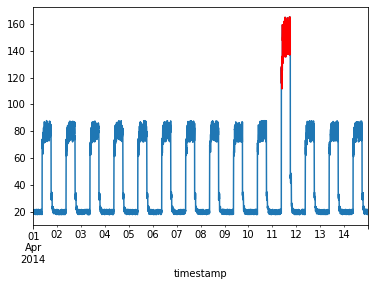

In [34]:
df_subset = df_test.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_test.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()


In [40]:
model.save('AnomaliesDetectorModel')

INFO:tensorflow:Assets written to: AnomaliesDetectorModel/assets


In [44]:
# To reload the model we can do
new_model = tf.keras.models.load_model('AnomaliesDetectorModel')

# Check its architecture
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 144, 32)           256       
                                                                 
 dropout_2 (Dropout)         (None, 144, 32)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 144, 16)          1808      
 ranspose)                                                       
                                                                 
 dropout_3 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                            

<AxesSubplot:>

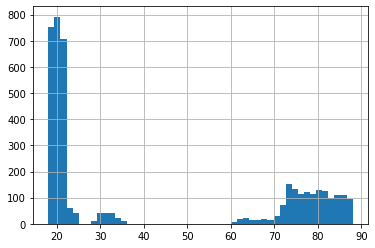

In [48]:
df_training.value.hist(bins=50)